# Basis-Modell für Regressionsfehler

Vorgehen:

- Sagen stets exakte Klasse voraus
- Schätzen die Festigkeit durch den Mittelwert für diese Klasse

In [1]:
import io, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn import model_selection, svm, metrics

import prepare

In [2]:
BASE_DIR = 'renamed'
DATA_OK = ['ok', 'near_ok_sonowechsel']
DATA_FEHLER = ['fehler_oel', 'fehler_leitungsversatz', 'fehler_terminversatz']

In [3]:
label = dict()
zugversuche = list()
# target labels for fail data
for idx, fname in enumerate(DATA_OK):
    label[fname] = idx
for idx, fname in enumerate(DATA_FEHLER):
    label[fname] = idx+2
for data_ok in DATA_OK:
    zugversuch = pd.read_csv(os.path.join(BASE_DIR, data_ok, 'zugversuch.csv'), sep=';', decimal=',')
    zugversuch.columns = ['nr', 'festigkeit']
    prefix = data_ok + '_'
    zugversuch['nr'] = zugversuch.nr.astype('str')
    zugversuch['key'] = prefix + zugversuch.nr
    zugversuch['label'] = label[data_ok]
    zugversuche.append(zugversuch)
for data_fehl in DATA_FEHLER:
    zugversuch = pd.read_csv(os.path.join(BASE_DIR, data_fehl, 'zugversuch.csv'), sep=';', decimal=',')
    prefix = data_fehl + '_'
    zugversuch.columns = ['nr', 'festigkeit']
    zugversuch['nr'] = zugversuch.nr.astype('str')
    zugversuch['key'] = prefix + zugversuch.nr
    zugversuch['label'] = label[data_fehl]
    zugversuche.append(zugversuch)
zugversuche = pd.concat(zugversuche, ignore_index=True)


Debugausgabe

In [4]:
zugversuche

,nr,festigkeit,key,label
0,1569,2600.000000,ok_1569,0
1,1570,2750.000000,ok_1570,0
2,1571,2770.000000,ok_1571,0
3,1572,2660.000000,ok_1572,0
4,1573,2810.000000,ok_1573,0
...,...,...,...,...
595,2505,1479.522827,fehler_terminversatz_2505,4
596,2506,2085.117920,fehler_terminversatz_2506,4
597,2507,2237.231201,fehler_terminversatz_2507,4
598,2508,2406.469482,fehler_terminversatz_2508,4


Gruppieren nach Label, Hinzufügen Mittelwert Festigkeit für diese Gruppe

In [5]:
zugversuche['fest_mean'] = zugversuche.groupby('label')['festigkeit'].transform('mean')

Gleiche Aufteilung Training/Test wie für echte Modelle

In [6]:
versuche_train, versuche_test = model_selection.train_test_split(zugversuche, test_size=0.2, random_state=42)

Vorhersage Trainingsdaten:

- truth: gemessene Festigkeit
- prediction: Mittelwert der Gruppe

In [7]:
festigkeit_train = versuche_train.festigkeit
y_pred_train = versuche_train.fest_mean
label_train = versuche_train.label

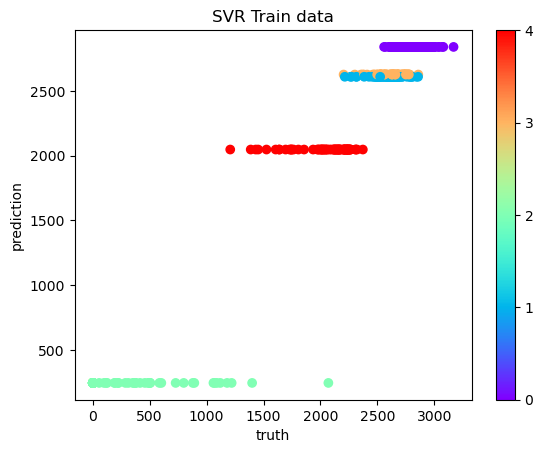

In [8]:
plt.scatter(festigkeit_train, y_pred_train, c=label_train, cmap='rainbow')
plt.title('SVR Train data')
plt.xlabel('truth')
plt.ylabel('prediction')
plt.colorbar(ticks=np.arange(5))
plt.savefig('base_model_train.png')

Vorhersage Testdaten

In [9]:
festigkeit_test = versuche_test.festigkeit
y_pred_test = versuche_test.fest_mean
label_test = versuche_test.label

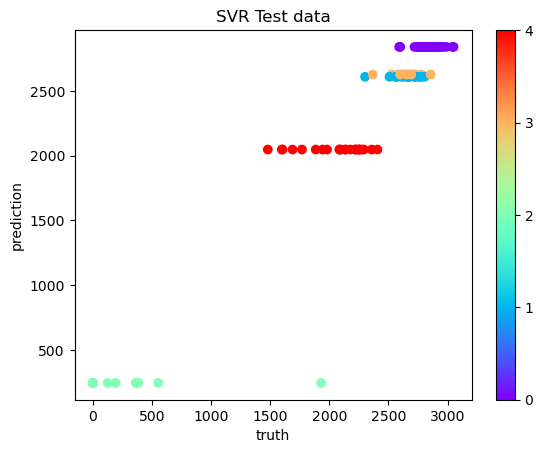

In [10]:
plt.scatter(festigkeit_test, y_pred_test, c=label_test, cmap='rainbow')
plt.title('SVR Test data')
plt.xlabel('truth')
plt.ylabel('prediction')
plt.colorbar(ticks=np.arange(5))
plt.savefig('base_model_test.png')

Fehlermessung zum Vergleich

In [11]:
mse_train = metrics.mean_squared_error(festigkeit_train, y_pred_train)
mse_test = metrics.mean_squared_error(festigkeit_test, y_pred_test)
print(f"MSE: train {mse_train:8.1f}, test: {mse_test:8.1f}")
print(f"RMSE: train {np.sqrt(mse_train):8.1f} test: {np.sqrt(mse_test):8.1f}")
mae_train = metrics.mean_absolute_error(festigkeit_train, y_pred_train)
mae_test = metrics.mean_absolute_error(festigkeit_test, y_pred_test)
print(f"MAE: train {mae_train:8.1f}, test: {mae_test:8.1f}")
# Nicht sinnvoll, da Zugfestigkeit 0 in Daten
#mapi_train = metrics.mean_absolute_percentage_error(festigkeit_train, y_pred_train)
#mapi_test = metrics.mean_absolute_percentage_error(festigkeit_test, y_pred_test)
#print(f"MAPI: train {mapi_train:8.1f}, test: {mapi_test:8.1f}")


MSE: train  48771.3, test:  50013.5
RMSE: train    220.8 test:    223.6
MAE: train    144.7, test:    135.5
